In [8]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Просмотр изображений.

Открытие изображения


In [2]:
img_original = Image.open("images/test/lenna.png")
img = np.array(img_original)

img_original_bw = Image.open("images/test/lenna_bw.png")
img_bw = np.array(img_original_bw)

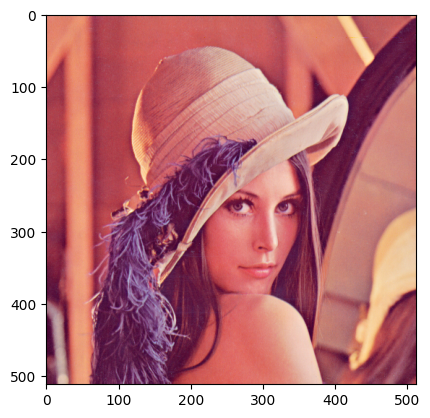

In [3]:
plt.imshow(img)

# Предобработка (YCbCr -> Downsample -> Blocks)

## 1. Переход из RGB в YCbCr


('Y', 'Cb', 'Cr')
(512, 512, 3)


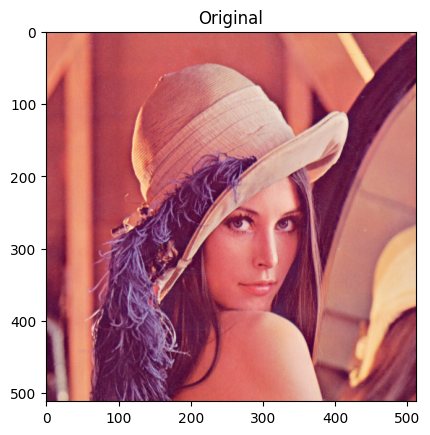

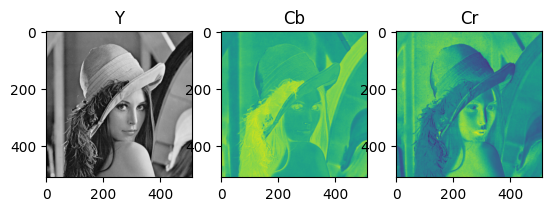

In [4]:
ycbcr = img_original.convert('YCbCr')

print(ycbcr.getbands())
print(np.array(ycbcr).shape)

(y, cb, cr) = ycbcr.split()

plt.figure()
plt.title("Original")
plt.imshow(img)

plt.figure()
plt.subplot(131)
plt.title("Y")
plt.imshow(y, cmap="gray")
plt.subplot(132)
plt.title("Cb")
plt.imshow(cb)
plt.subplot(133)
plt.title("Cr")
plt.imshow(cr)
plt.show()

Теперь напишем свое преобраование

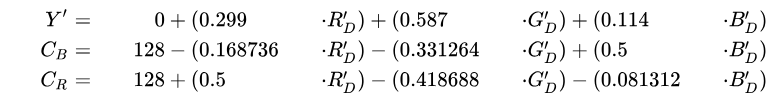

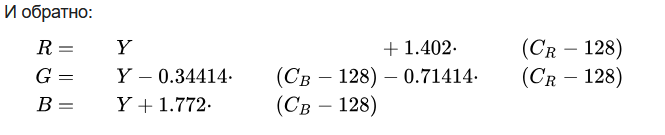

In [5]:
def RGB2YCBCR(img):
    img = img.astype(np.float32)
    # take channels
    tr = img.transpose(2, 0, 1)
    # take r g b
    r, g, b = tr
        
    y = 0.299 * r + 0.587 * g + 0.114 * b
    cb = 128 + -0.168736 * r - 0.331264 * g + 0.5 * b
    cr = 128 + 0.5 * r - 0.418688 * g - 0.081312 * b
        
    ycbcr = np.dstack((y, cb, cr))
    return np.clip(ycbcr, 0, 255).astype(np.uint8)

def YCBCR2RGB(img):
    img = img.astype(np.float32)
    # get components
    tr = img.transpose(2, 0, 1)
    # take r g b + normalize
    y, cb, cr = tr

    r = y + 1.402 * (cr - 128)
    g = y - 0.344136 * (cb - 128) - 0.714136 * (cr - 128)
    b = y + 1.772 * (cb - 128)

    rgb = np.dstack((r, g, b))
    return np.clip(rgb, 0, 255).astype(np.uint8)

Проверим работу алгоритма

In [6]:
img_ycbcr = RGB2YCBCR(img)

In [7]:
restored_img = YCBCR2RGB(img_ycbcr)

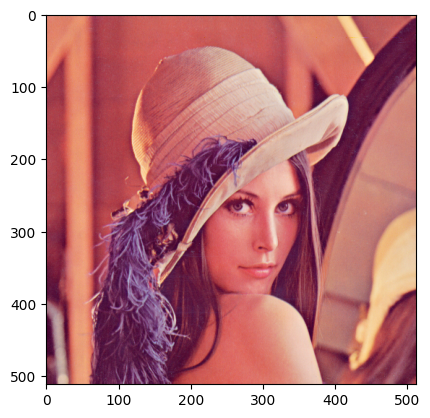

In [8]:
plt.imshow(restored_img)

## 2. Даунсэмплинг каналов Cb и Сr c коэффициентом 2 по каждой оси.

In [9]:
def downsample(img_channel, factor: int = 2):
    h, w = img_channel.shape
    # Вычисляем новые размеры (округляя вниз)
    new_h = h // factor
    new_w = w // factor
    
    # Создаём массив для уменьшенного канала
    downsampled = np.zeros((new_h, new_w), dtype=np.float32)
    
    # Усредняем блоки factor x factor
    for i in range(new_h):
        for j in range(new_w):
            block = img_channel[i*factor:(i+1)*factor, j*factor:(j+1)*factor]
            downsampled[i,j] = np.mean(block)
    
    return downsampled.astype(np.uint8)

def bilinear_upsample(img_channel, factor: int = 2):
    h, w = img_channel.shape
    new_h, new_w = h * factor, w * factor
    
    # Создаём координатные сетки
    x = np.linspace(0, w-1, new_w)
    y = np.linspace(0, h-1, new_h)
    
    # Билинейная интерполяция
    upsampled = np.zeros((new_h, new_w), dtype=np.uint8)
    for i in range(new_h):
        for j in range(new_w):
            x0, y0 = int(np.floor(x[j])), int(np.floor(y[i]))
            x1, y1 = min(x0 + 1, w-1), min(y0 + 1, h-1)
            
            # Доли для интерполяции
            x_alpha = x[j] - x0
            y_alpha = y[i] - y0
            
            # Интерполяция по 4 точкам
            val = (1-x_alpha)*(1-y_alpha)*img_channel[y0,x0] + \
                  x_alpha*(1-y_alpha)*img_channel[y0,x1] + \
                  (1-x_alpha)*y_alpha*img_channel[y1,x0] + \
                  x_alpha*y_alpha*img_channel[y1,x1]
            
            upsampled[i,j] = np.clip(val, 0, 255)
    
    return upsampled

In [10]:
# Получим каналы
y, cb, cr = img_ycbcr.transpose(2, 0, 1)

In [11]:
# Даунсемплинг
cb_ds = downsample(cb)
cr_ds = downsample(cr)
print(cb_ds.shape, cr_ds.shape)

(256, 256) (256, 256)


In [12]:
# Upsampling
cb_ups = bilinear_upsample(cb_ds)
cr_ups = bilinear_upsample(cr_ds)

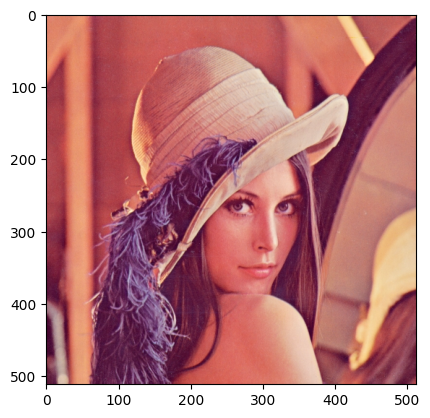

In [13]:
# Проверка
updowns_ycbcr = np.dstack((y, cb_ups, cr_ups))
updowsn_rgb = YCBCR2RGB(updowns_ycbcr)
plt.imshow(updowsn_rgb)

## 3. Разбиение на блоки 8x8

In [14]:
def block_partioning(img, size: int = 8, fill: int = 0):
    """
    return: 5d массив из блоков (h_blocks, w_blocks, h_block, w_block, channels)
    """

    h, w = img.shape[0], img.shape[1]

    # Вычисляем количество блоков
    blocks_h = (h + size - 1) // size
    blocks_w = (w + size - 1) // size

    # Дополняем изображение
    padded_h = blocks_h * size
    padded_w = blocks_w * size

    if img.ndim == 2:
        padded = np.full((padded_h, padded_w), fill, dtype=img.dtype)
        padded[:h, :w] = img
    else:  # 3D (цветное)
        padded = np.full((padded_h, padded_w, img.shape[2]), fill, dtype=img.dtype)
        padded[:h, :w, :] = img

    blocks = []
    # Разбиение на блоки
    for i in range(blocks_h):
        row_blocks = []
        for j in range(blocks_w):
            block = padded[i*size:(i+1)*size, j*size:(j+1)*size]
            row_blocks.append(block)
        blocks.append(row_blocks)
    
    return np.array(blocks)


In [15]:
def merge_blocks(blocks, original_shape: int):

    num_blocks_h, num_blocks_w, size = blocks.shape[0], blocks.shape[1], blocks.shape[2]
    h, w = original_shape[0], original_shape[1]

    # Создаём пустое изображение с дополнением
    padded_h = num_blocks_h * size
    padded_w = num_blocks_w * size


    if blocks.ndim == 5:  # Цветное
        merged = np.zeros((padded_h, padded_w, blocks.shape[4]), dtype=blocks.dtype)
    else:  # (H, W)
        merged = np.zeros((padded_h, padded_w), dtype=blocks.dtype)
    
    # Заполняем блоки
    for i in range(num_blocks_h):
        for j in range(num_blocks_w):
            merged[i*size:(i+1)*size, 
                  j*size:(j+1)*size] = blocks[i, j]
    
    return merged[:h, :w]

In [16]:
blocks_ycbcr = block_partioning(img_ycbcr)
print(blocks_ycbcr.shape)

(64, 64, 8, 8, 3)


In [17]:
merged_ycbcr = merge_blocks(blocks_ycbcr, img_ycbcr.shape)
print(np.array_equal(merged_ycbcr, img_ycbcr))

True


Проверка там где не разбивается нацело.

In [56]:
question_original = Image.open("images/test/question.png")
img_q = np.array(question_original)
print(img_q.shape)
h, w = img_q.shape[0], img_q.shape[1]

(603, 604, 3)


In [ ]:
# to ycbcr
img_q_ycbcr = RGB2YCBCR(img_q)
y, cb, cr = img_q_ycbcr.transpose(2, 0, 1)
cb_ds = downsample(cb)
cr_ds = downsample(cr)
# downsample
# skipped

# blocks partition
blocks_ycbcr_q = block_partioning(img_q_ycbcr)
print(blocks_ycbcr_q.shape)

# blocks merge
merged_ycbcr_q = merge_blocks(blocks_ycbcr_q, img_q_ycbcr.shape)
print(np.array_equal(merged_ycbcr_q, img_q_ycbcr))

(76, 76, 8, 8, 3)
True


In [49]:
y_bl = block_partioning(y)
cb_ds_b = block_partioning(cb_ds)
cr_ds_b = block_partioning(cr_ds)

In [50]:
cb_ds_b.shape

(38, 38, 8, 8)

In [52]:
y_bl.shape

(76, 76, 8, 8)

In [57]:
y_rest = merge_blocks(y_bl, (h, w))
y_rest.shape

(603, 604)

In [ ]:
603

75

## Объединение Preprocess функций в одно

In [20]:
# RGB -> YCbCr
ycbcr = RGB2YCBCR(img)
# YCbCr -> Downsample
y, cb, cr = ycbcr.transpose(2, 0, 1)
cb = downsample(cb)
cr = downsample(cr)
# Downsampled -> Blocks 8x8
y_blocks = block_partioning(y)
cb_blocks = block_partioning(cb)
cr_blocks = block_partioning(cr)

In [21]:
# Проверка размерностей
print(y_blocks.shape)
print(cb_blocks.shape)
print(cr_blocks.shape)

(64, 64, 8, 8)
(32, 32, 8, 8)
(32, 32, 8, 8)


# DCT + QUANTIZATION

## 4.  Прямого и обратного DCT-II 2D для блока размера NxN.

In [22]:
def dct_matrix(N=8):
    C = np.zeros((N, N))
    for u in range(N):
        for x in range(N):
            if u == 0:
                C[u, x] = np.sqrt(1/N)
            else:
                C[u, x] = np.sqrt(2/N) * np.cos((2*x + 1) * u * np.pi / (2*N))
    return C

In [23]:
# Функция dct2d для работы с каналами.
def dct2d(channel):
    block_h, block_w = channel.shape[0], channel.shape[1]

    # Рассчитываем матрицу C
    C = dct_matrix(8)

    dct = []
    for i in range(block_h):
        dct_row = []
        for j in range(block_w):
            block = channel[i, j]
            # Центрирование
            block = block.astype(np.float32) - 128
            # Матричное умножение
            coef = C @ block @ C.T
            # Добавляем блок в матрицу блоков
            dct_row.append(coef)

        dct.append(dct_row)
    
    return np.array(dct)

def idct2d(block_dct_coefs):
    block_h, block_w = block_dct_coefs.shape[0], block_dct_coefs.shape[1]

    # Рассчитываем матрицу C
    C = dct_matrix(8)

    channel = []
    for i in range(block_h):
        channel_row = []
        for j in range(block_w):
            # Берем блок коэффициентов
            dct_coeffs = block_dct_coefs[i, j]
            # Рассчитываем сам блок
            block = C.T @ dct_coeffs @ C
            # Добавляем 128 и преобразовываем в int
            channel_block = np.clip(block + 128, 0, 255).astype(np.uint8)
            # Добавляем обратно в матрицу
            channel_row.append(channel_block)

        channel.append(channel_row)

    return np.array(channel)

### Проверка корректности работы.

In [24]:
# for y
result_y = dct2d(y_blocks)
idct_y = idct2d(result_y)

# for cb
result_cb = dct2d(cb_blocks)
idct_cb  = idct2d(result_cb)

# for cr
result_cr = dct2d(cr_blocks)
idct_cr  = idct2d(result_cr)

Убедимся в правильности работы алгоритма dct

In [25]:
# Blocks
n_y = merge_blocks(idct_y, y.shape)
n_cb = merge_blocks(idct_cb, cb.shape)
n_cr = merge_blocks(idct_cr, cr.shape)
# Upsampling
cb_upsample, cr_upsample = bilinear_upsample(n_cb), bilinear_upsample(n_cr)
# YCbCr -> RGB
n_img = YCBCR2RGB(np.dstack((n_y, cb_upsample, cr_upsample)))

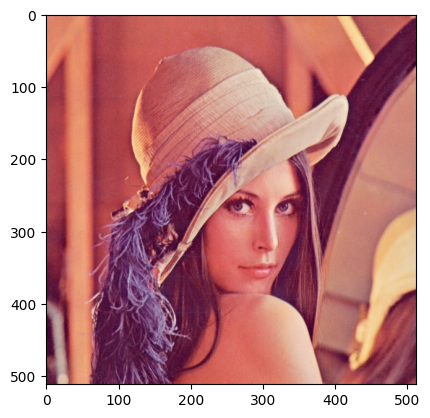

In [26]:
plt.imshow(n_img)

## 5. Квантование +изменения матрицы квантования в зависимости от уровня сжатия.

Матрицы квантования:

In [27]:
Q_Y = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

Q_C = np.array([
    [17, 18, 24, 47, 99, 99, 99, 99],
    [18, 21, 26, 66, 99, 99, 99, 99],
    [24, 26, 56, 99, 99, 99, 99, 99],
    [47, 66, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99]
])

Для оптимизации мы пропишем квантование вместе с dct

In [28]:
def get_quantization_matrix(base_matrix, quality):
    if quality <= 0:
        scale = 5000
    elif quality >= 100:
        scale = 1
    else:
        scale = 5000 / quality  # Нелинейная зависимость
    
    scaled_matrix = np.clip(np.round(base_matrix * scale / 100), 1, 255)
    return scaled_matrix

In [29]:
def quantize(dct_coeffs, q_matrix):
    return np.round(dct_coeffs / q_matrix).astype(np.int32)

def dequantize(quantized_coeffs, q_matrix):
    return quantized_coeffs * q_matrix

Теперь напишем функцию DCT + Квантование

In [30]:
# Функция dct2d для работы с каналами.
def dct2d(channel, q_matrix):
    block_h, block_w = channel.shape[0], channel.shape[1]

    # Рассчитываем матрицу C
    C = dct_matrix(8)

    dct = []
    for i in range(block_h):
        dct_row = []
        for j in range(block_w):
            block = channel[i, j]
            # Центрирование
            block = block.astype(np.float32) - 128
            # Матричное умножение
            coef = C @ block @ C.T

            # квантование
            quantized = quantize(coef, q_matrix)

            # Добавляем блок в матрицу блоков
            dct_row.append(quantized)

        dct.append(dct_row)
    
    return np.array(dct)

def idct2d(block_dct_coefs, q_matrix):
    block_h, block_w = block_dct_coefs.shape[0], block_dct_coefs.shape[1]

    # Рассчитываем матрицу C
    C = dct_matrix(8)

    channel = []
    for i in range(block_h):
        channel_row = []
        for j in range(block_w):
            # Берем блок коэффициентов
            dct_coeffs = block_dct_coefs[i, j]

            # Обратное квантование
            dequantized = dequantize(dct_coeffs, q_matrix)

            # Рассчитываем сам блок
            block = C.T @ dequantized @ C
            # Добавляем 128 и преобразовываем в int
            channel_block = np.clip(block + 128, 0, 255).astype(np.uint8)
            # Добавляем обратно в матрицу
            channel_row.append(channel_block)

        channel.append(channel_row)

    return np.array(channel)

Проверим работу наших алгоритмов.


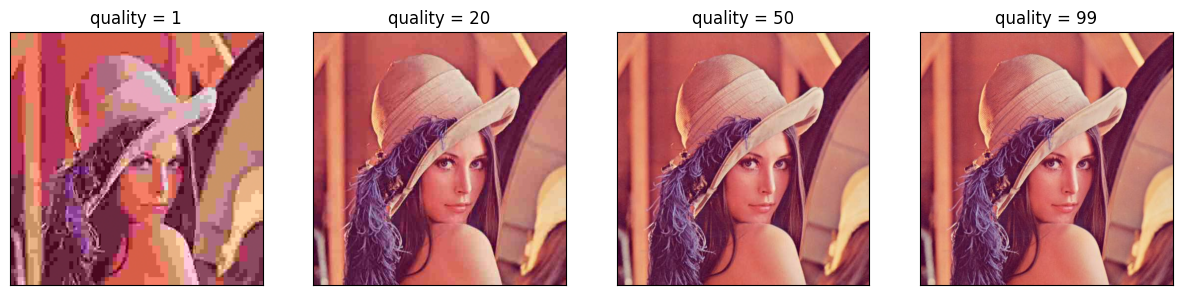

In [31]:
fig, axes = plt.subplots(1, 4, figsize=(15, 8))

qualities = [1, 20, 50, 99]
for i in range(4):

    quality = qualities[i]
    Q_Y_Quality = get_quantization_matrix(Q_Y, quality)
    Q_C_Quality = get_quantization_matrix(Q_C, quality)

    # for y
    result_y = dct2d(y_blocks, Q_Y_Quality)
    idct_y = idct2d(result_y, Q_Y_Quality)

    # for cb
    result_cb = dct2d(cb_blocks, Q_C_Quality)
    idct_cb  = idct2d(result_cb, Q_C_Quality)

    # for cr
    result_cr = dct2d(cr_blocks, Q_C_Quality)
    idct_cr  = idct2d(result_cr, Q_C_Quality)

    # Blocks
    n_y = merge_blocks(idct_y, y.shape)
    n_cb = merge_blocks(idct_cb, cb.shape)
    n_cr = merge_blocks(idct_cr, cr.shape)
    # Upsampling
    cb_upsample, cr_upsample = bilinear_upsample(n_cb), bilinear_upsample(n_cr)
    # YCbCr -> RGB
    n_img = YCBCR2RGB(np.dstack((n_y, cb_upsample, cr_upsample)))  

    axes[i].imshow(n_img)
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
    axes[i].set_title(f"quality = {quality}") 

    

## 7. Зигзаг обхода матрицы NxN

In [32]:
def zigzag_indices(n=8):
    indices = []
    for d in range(2 * n - 1):  # Все диагонали
        if d < n:
            for i in range(d + 1):
                j = d - i
                if d % 2 == 0:
                    indices.append((i, j))
                else:
                    indices.append((j, i))
        else:
            for i in range(d - n + 1, n):
                j = d - i
                if d % 2 == 0:
                    indices.append((i, j))
                else:
                    indices.append((j, i))
    return indices

def zigzag_scan(block):
    indices = zigzag_indices(len(block))
    return [block[i][j] for (i,j) in indices]


In [33]:
def inverse_zigzag(sequence, n=8):
    block = np.zeros((n, n))
    indices = zigzag_indices(n)
    for k, (i, j) in enumerate(indices):
        block[i][j] = sequence[k]
    return block

## 8.  Разностного кодирования DC коэффициентов + Переменного кодирования разностей DC и AC коэффициентов.

Таблицы

In [34]:
from huffman_tables import *

In [35]:
# Класс для работы с битовой строкой
class BitStream:
    def __init__(self):
        self.bits = []
        self.current_byte = 0
        self.bit_pos = 7
    
    def add_bits(self, bit_str):
        for bit in bit_str:
            if bit == '1':
                self.current_byte |= (1 << self.bit_pos)
            self.bit_pos -= 1
            
            if self.bit_pos < 0:
                self.bits.append(self.current_byte)
                self.current_byte = 0
                self.bit_pos = 7
    
    def get_bytes(self):
        # Добавляем неполный байт (если есть)
        if self.bit_pos != 7:
            self.bits.append(self.current_byte)
        return bytes(self.bits)

In [36]:
# Определение категории для значения
def get_category(value):
    if value == 0:
        return 0
    abs_val = abs(value)
    return int(np.floor(np.log2(abs_val))) + 1

Работа с DC коэффициентами

In [37]:
# 1. Разностное кодирование DC коэффициентов
def encode_dc_coefficients(dc_components):
    differences = [dc_components[0]]  # Первый DC сохраняем как есть
    for i in range(1, len(dc_components)):
        differences.append(dc_components[i] - dc_components[i-1])
    return differences


# 2. Кодирование dc коэффициентов
def encode_dc(dc_components, component_type='lum'):
    dc_diff = encode_dc_coefficients(dc_components)

    """Кодирование DC с выбором таблицы"""
    table = huffman_dc if component_type == 'lum' else huffman_dc_chrominance
    bitstream = BitStream()

    for diff in dc_diff:
        category = get_category(diff)
        bitstream.add_bits(table[category][0])  # Добавляем код Хаффмана
        
        if category != 0:
            # Кодирование значения (дополнительный код)
            val = diff if diff > 0 else (abs(diff) ^ ((1 << category) - 1))
            bitstream.add_bits(f"{val:0{category}b}")  # Добавляем значение

    return bitstream.get_bytes()

Работа с AC коэффициентами

In [38]:
def rle_encode(ac):
    n = len(ac)
    encoded = []
    zero_counter = 0
    
    for i in range(n):
        if ac[i] == 0:
            zero_counter+=1
            if zero_counter == 16:
                encoded.append((15, 0)) # ZRL
                zero_counter = 0
        else:
            category = get_category(ac[i])
            encoded.append((zero_counter, category))
            encoded.append(ac[i])  # Сохраняем значение
            zero_counter = 0

    encoded.append((0,0))  # EOB
    return encoded

def encode_ac_rle_str(block, component_type: str):
        """RLE + Кодирование AC коэффициентов"""
        ac_table = huffman_ac if component_type == 'lum' else huffman_ac_chrominance
        bitstream = BitStream()
        
        for item in block:
            if isinstance(item, tuple):  # (Run, Size)
                bitstream.add_bits(ac_table[item][0])
            else:  # Значение коэффициента
                coeff = item
                category = get_category(coeff)
                if coeff > 0:
                    bitstream.add_bits(f"{coeff:0{category}b}")
                else:
                    bitstream.add_bits(f"{(abs(coeff)^((1<<category)-1)):0{category}b}")
        
        return bitstream.get_bytes()

def encode_ac_rle(ac_coefs, type: str):
    bits = []
    for ac_block in ac_coefs:
        rle_encoded_ac = rle_encode(ac_block)
        bit_stream = encode_ac_rle_str(rle_encoded_ac, type)
        bits.append(bit_stream)

    return bits

Декодирование

Метод для кодировки канала.

In [39]:
def encoding(channel, type: str):
    """
    Кодирование AC и DC коэффициентов одного канала.
    """
    
    y_h, y_w = channel.shape[0], channel.shape[1]

    dc_coefs = []
    ac_coefs = []
    for i in range(y_h):
        for j in range(y_w):
            block = channel[i, j]
            # 1. Zig Zag
            z_block = zigzag_scan(block)

            # Add to arrays
            dc_coefs.append(z_block[0])
            ac_coefs.append(z_block[1:])
    

    # 4. Кодирование Хаффманом
    dc_bits = encode_dc(dc_coefs, type)
    ac_bits = encode_ac_rle(ac_coefs, type)
    
    return dc_bits, ac_bits


Проверка.

In [40]:
# result_y, result_cb, result_cr - после dct+quantum

y_encoded = encoding(result_y, 'lum')
cb_encoded = encoding(result_cb, 'chrominance')
cr_encoded = encoding(result_cr, 'chrominance')

Тест всяких разных вещей.